# ONLY the Adede Variables

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

In [5]:
X_train_1M, y_train_1M = read_train_data(data_dir, experiment='one_month_forecast_adede_VCI1M')
X_test_1M, y_test_1M = read_test_data(data_dir, experiment='one_month_forecast_adede_VCI1M')

ds = xr.merge([y_train_1M, y_test_1M]).sortby('time').sortby('lat')
d_ = xr.merge([X_train_1M, X_test_1M]).sortby('time').sortby('lat')
ds_1M = xr.merge([ds, d_])

In [6]:
X_train_3M, y_train_3M = read_train_data(data_dir, experiment='one_month_forecast_adede_VCI3M')
X_test_3M, y_test_3M = read_test_data(data_dir, experiment='one_month_forecast_adede_VCI3M')

ds = xr.merge([y_train_3M, y_test_3M]).sortby('time').sortby('lat')
d_ = xr.merge([X_train_3M, X_test_3M]).sortby('time').sortby('lat')
ds_3M = xr.merge([ds, d_])

In [183]:
ds_3M

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 449)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-12-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI3M    (time, lat, lon) float64 nan nan nan nan ... 35.92 61.44 33.08
    RCI1M    (time, lat, lon) float64 2.806e-09 1.921e-09 0.04287 ... nan nan
    RCI3M    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    RFE1M    (time, lat, lon) float64 2.911e-08 2.504e-08 0.2845 ... nan nan nan
    RFE3M    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SPI1     (time, lat, lon) float64 1.488 0.8602 0.2544 0.1792 ... nan nan nan
    SPI3     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VCI1M    (time, lat, lon) float64 39.36 18.57 19.15 12.16 ... nan nan nan

In [8]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train_1M.VCI1M)

In [12]:
bline_pred_3M = read_pred_data('previous_month', data_dir, experiment='one_month_forecast_adede_only_target_VCI3M')[-1].where(~mask)
lstm_pred_3M = read_pred_data('rnn', data_dir, experiment='one_month_forecast_adede_only_target_VCI3M')[-1].where(~mask)

bline_pred_1M = read_pred_data('previous_month', data_dir, experiment='one_month_forecast_adede_only_target_VCI1M')[-1].where(~mask)
lstm_pred_1M = read_pred_data('rnn', data_dir, experiment='one_month_forecast_adede_only_target_VCI1M')[-1].where(~mask)



## Explore Predicted vs. Observed Distributions

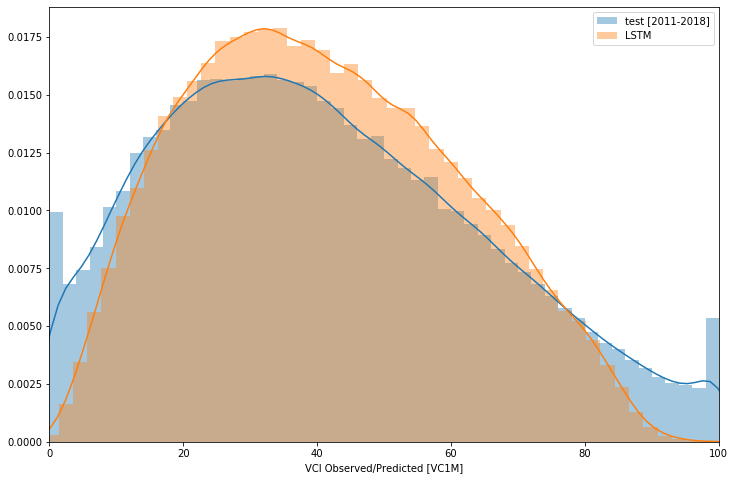

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test_1M.VCI1M), ax=ax, label='test [2011-2018]')
sns.distplot(drop_nans_and_flatten(lstm_pred_1M), ax=ax, label='LSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted [VC1M]');

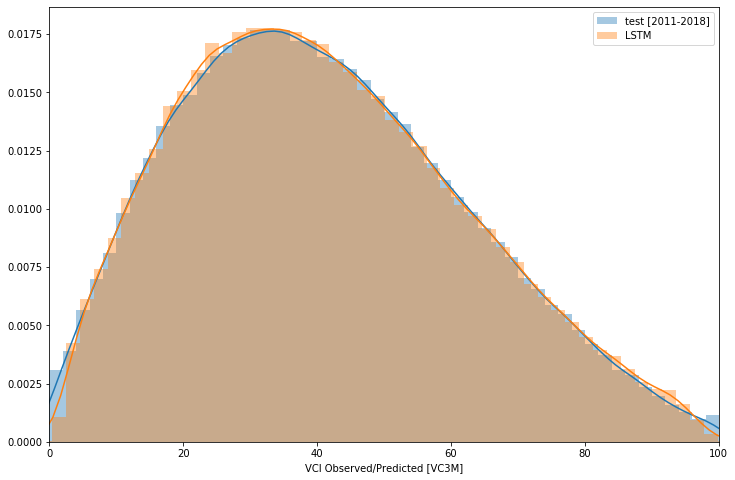

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test_3M.VCI3M), ax=ax, label='test [2011-2018]')
sns.distplot(drop_nans_and_flatten(lstm_pred_3M), ax=ax, label='LSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted [VC3M]');

## Explore how perform in each month

In [14]:
from src.analysis import annual_scores

In [15]:
# load the monthly scores dictionary
true_data_experiment = 'one_month_forecast_adede_VCI1M'
experiment = 'one_month_forecast_adede_only_target_VCI1M'

monthly_scores_1M = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'rnn'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment=experiment,
    true_data_experiment=true_data_experiment,
    target_var='VCI1M',
    verbose=False,
    to_dataframe=True
)
monthly_scores_1M['time'] = monthly_scores_1M.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores_1M.head()

,month,previous_month,rnn,year,metric,time
0,1.0,9.930670,9.124643,2011.0,rmse,2011-01-01
1,2.0,8.398267,7.946727,2011.0,rmse,2011-02-01
2,3.0,9.340854,9.777861,2011.0,rmse,2011-03-01
3,4.0,11.446635,12.372978,2011.0,rmse,2011-04-01
4,5.0,13.610549,11.299189,2011.0,rmse,2011-05-01


In [17]:
# load the monthly scores dictionary
true_data_experiment = 'one_month_forecast_adede_VCI3M'
experiment = 'one_month_forecast_adede_only_target_VCI3M'

monthly_scores_3M = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'rnn'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment=experiment,
    true_data_experiment=true_data_experiment,
    target_var='VCI3M',
    verbose=False,
    to_dataframe=True
)
monthly_scores_3M['time'] = monthly_scores_3M.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores_3M.head()

,month,previous_month,rnn,year,metric,time
0,1.0,7.630519,2.854957,2011.0,rmse,2011-01-01
1,2.0,6.328749,2.688271,2011.0,rmse,2011-02-01
2,3.0,5.443582,2.954605,2011.0,rmse,2011-03-01
3,4.0,5.665763,3.788924,2011.0,rmse,2011-04-01
4,5.0,6.485335,3.738657,2011.0,rmse,2011-05-01


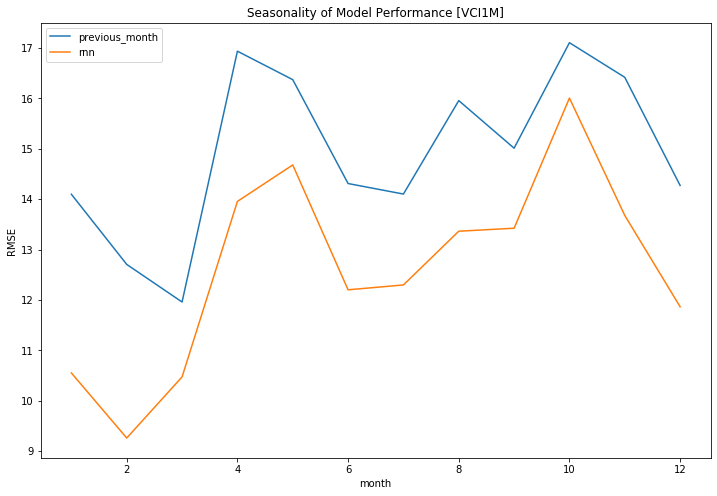

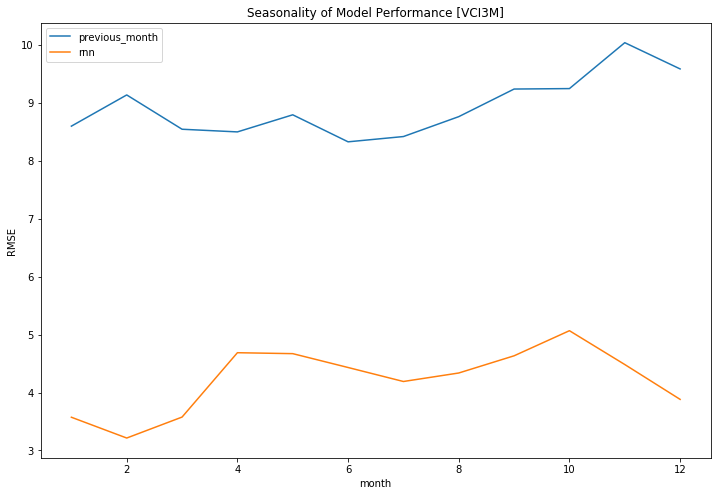

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'rnn',]: # 
    (
        monthly_scores_1M
        .where(monthly_scores_1M.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance [VCI1M]')
ax.set_ylabel('RMSE');


fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'rnn',]: # 
    (
        monthly_scores_3M
        .where(monthly_scores_3M.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance [VCI3M]')
ax.set_ylabel('RMSE');


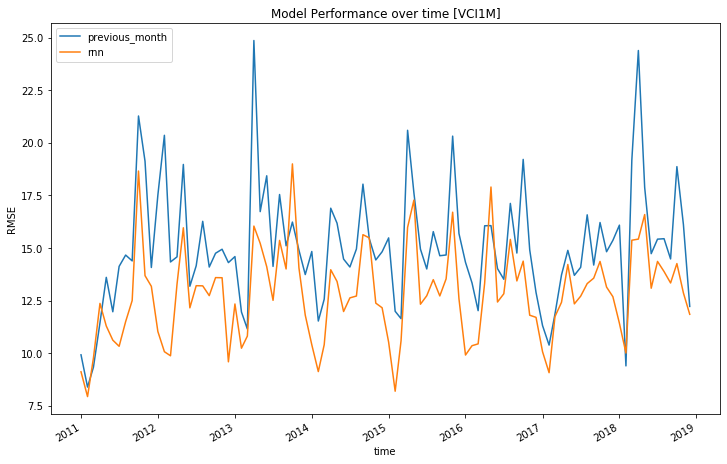

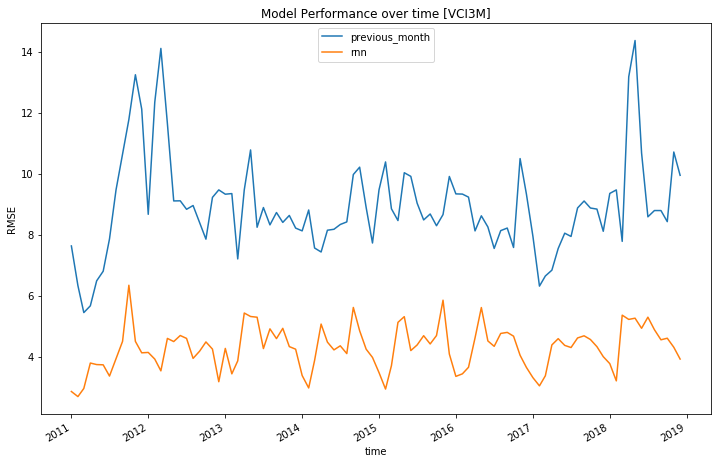

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'rnn']: # 
    (
        monthly_scores_1M
        .where(monthly_scores_1M.metric == 'rmse')
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time [VCI1M]')
ax.set_ylabel('RMSE');


fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'rnn']: # 
    (
        monthly_scores_3M
        .where(monthly_scores_3M.metric == 'rmse')
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time [VCI3M]')
ax.set_ylabel('RMSE');


# Model Performance Comparisons

In [24]:
from src.analysis import spatial_rmse, spatial_r2
%autoreload 2

In [26]:
lstm_rmse_1M = spatial_rmse(
    y_test_1M.VCI1M.transpose("time", "lat", "lon"), 
    lstm_pred_1M.transpose("time", "lat", "lon")
)

# --------
bline_rmse_1M = spatial_rmse(
    y_test_1M.VCI1M.transpose("time", "lat", "lon"), 
    bline_pred_1M.transpose("time", "lat", "lon")
)

# --------

# calculate mean performance scores
lstm_mean_1M = lstm_rmse_1M.mean().values
bline_mean_1M = bline_rmse_1M.mean().values

print("lstm_mean_1M: ", lstm_mean_1M)
print("bline_mean_1M: ", bline_mean_1M)

# ----------------------
# ----------------------

lstm_rmse_3M = spatial_rmse(
    y_test_3M.VCI3M.transpose("time", "lat", "lon"), 
    lstm_pred_3M.transpose("time", "lat", "lon")
)

# --------
bline_rmse_3M = spatial_rmse(
    y_test_3M.VCI3M.transpose("time", "lat", "lon"), 
    bline_pred_3M.transpose("time", "lat", "lon")
)

# --------

# calculate mean performance scores
lstm_mean_3M = lstm_rmse_3M.mean().values
bline_mean_3M = bline_rmse_3M.mean().values
print("lstm_mean_3M: ", lstm_mean_3M)
print("bline_mean_3M: ", bline_mean_3M)

lstm_mean_1M:  12.452850280700119
bline_mean_1M:  14.637392005308326
lstm_mean_3M:  4.143308722606744
bline_mean_3M:  8.688644197143603


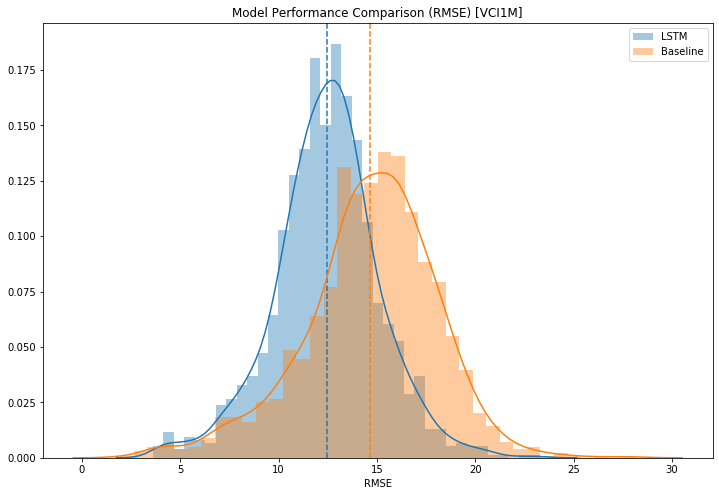

In [27]:
rmses = [lstm_rmse_1M, bline_rmse_1M]
means = [lstm_mean_1M, bline_mean_1M]
labels = ['LSTM', 'Baseline']
colors = sns.color_palette()[:len(means)]

assert (len(rmses) == len(means)) &  (len(labels) == len(colors))
assert (len(rmses) == len(labels))

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(rmses)):
    rmse = rmses[i]
    mean = means[i]
    label = labels[i]
    color = colors[i]
    sns.distplot(
        drop_nans_and_flatten(rmse), ax=ax,
        label=label, color=color
    )
    ax.axvline(mean, ls='--', color=color) # , label=f'{label}_mean'

plt.legend()
ax.set_xlabel('RMSE');
ax.set_title('Model Performance Comparison (RMSE) [VCI1M]');
# ax.set_ylabel('Density')

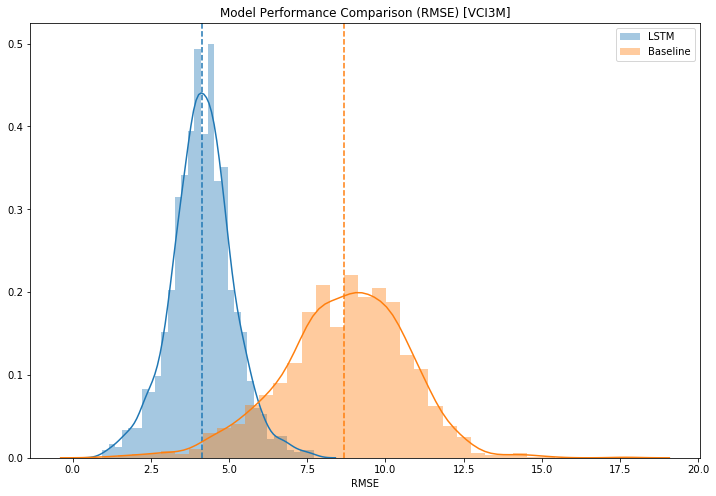

In [28]:
rmses = [lstm_rmse_3M, bline_rmse_3M]
means = [lstm_mean_3M, bline_mean_3M]
labels = ['LSTM', 'Baseline']
colors = sns.color_palette()[:len(means)]

assert (len(rmses) == len(means)) &  (len(labels) == len(colors))
assert (len(rmses) == len(labels))

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(rmses)):
    rmse = rmses[i]
    mean = means[i]
    label = labels[i]
    color = colors[i]
    sns.distplot(
        drop_nans_and_flatten(rmse), ax=ax,
        label=label, color=color
    )
    ax.axvline(mean, ls='--', color=color) # , label=f'{label}_mean'

plt.legend()
ax.set_xlabel('RMSE');
ax.set_title('Model Performance Comparison (RMSE) [VCI3M]');
# ax.set_ylabel('Density')

## Spatial Plots of the Model Performance

LSTM RMSE:  12.452850280700119
Baseline RMSE:  14.637392005308326


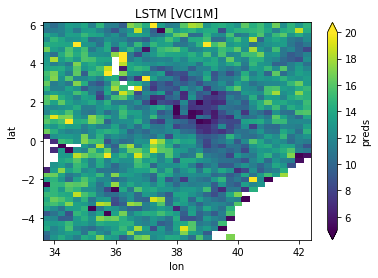

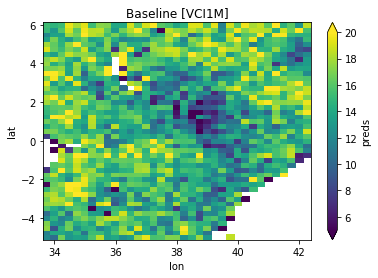

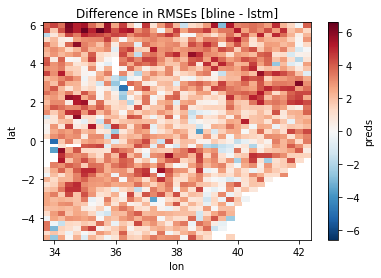

In [31]:
# VCI 1M
fig, ax = plt.subplots()
lstm_rmse_1M.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('LSTM [VCI1M]')

fig, ax = plt.subplots()
bline_rmse_1M.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('Baseline [VCI1M]')

fig, ax = plt.subplots()
(bline_rmse_1M - lstm_rmse_1M).plot(ax=ax)
ax.set_title('Difference in RMSEs [bline - lstm]')

print("LSTM RMSE: ", lstm_rmse_1M.mean().values)
print("Baseline RMSE: ", bline_rmse_1M.mean().values)

LSTM RMSE:  4.143308722606744
Baseline RMSE:  8.688644197143603


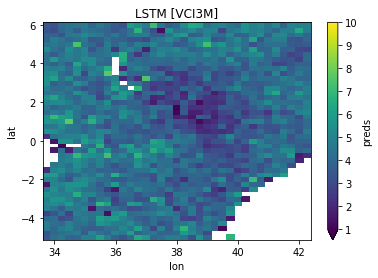

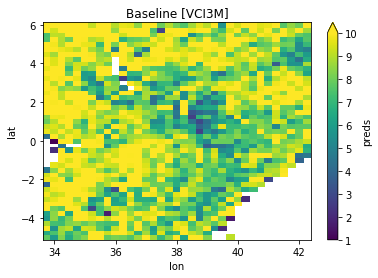

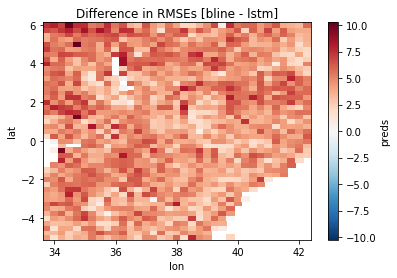

In [34]:
# VCI 3M
fig, ax = plt.subplots()
lstm_rmse_3M.plot(vmin=1, vmax=10, ax=ax)
ax.set_title('LSTM [VCI3M]')

fig, ax = plt.subplots()
bline_rmse_3M.plot(vmin=1, vmax=10, ax=ax)
ax.set_title('Baseline [VCI3M]')

fig, ax = plt.subplots()
(bline_rmse_3M - lstm_rmse_3M).plot(ax=ax)
ax.set_title('Difference in RMSEs [bline - lstm]')

print("LSTM RMSE: ", lstm_rmse_3M.mean().values)
print("Baseline RMSE: ", bline_rmse_3M.mean().values)

# Event Hits/Misses

In [138]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Quintiles of Vegetation Condition Index

In [143]:
def calculate_quintiles(da: xr.DataArray, new_variable_name: str = 'quintiles'):
    bins = [0.0, 20.0, 40.0, 60.0, 80.0]
    result = xr.apply_ufunc(np.digitize, da, bins)
    result = result.rename(new_variable_name)
    return result

mask = get_ds_mask(ds_1M.VCI1M)
true_qs_1M = calculate_quintiles(y_test_1M.VCI1M).where(~mask)
pred_qs_1M = calculate_quintiles(lstm_pred_1M.where(lstm_pred_1M > 0, 0).load()).where(~mask)
bline_qs_1M = calculate_quintiles(bline_pred_1M.load()).where(~mask)

true_qs_3M = calculate_quintiles(y_test_3M.VCI3M).where(~mask)
pred_qs_3M = calculate_quintiles(lstm_pred_3M.where(lstm_pred_3M > 0, 0).load()).where(~mask)
bline_qs_3M = calculate_quintiles(bline_pred_3M.load()).where(~mask)

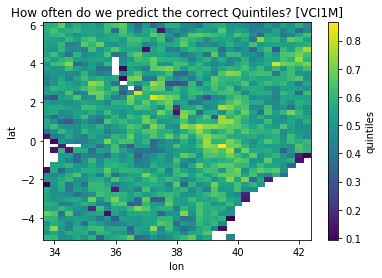

In [148]:
fig, ax = plt.subplots()
(pred_qs_1M == true_qs_1M).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Quintiles? [VCI1M]');

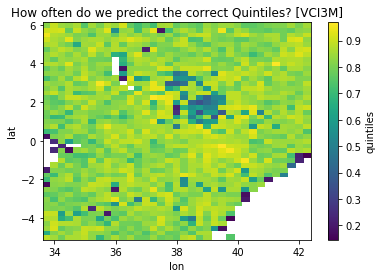

In [149]:
fig, ax = plt.subplots()
(pred_qs_3M == true_qs_3M).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Quintiles? [VCI3M]');

In [150]:
times_1M = true_qs_1M.time.values
true_np_1M = true_qs_1M.stack(pixel=['lat', 'lon']).values.flatten()
preds_np_1M = pred_qs_1M.stack(pixel=['lat', 'lon']).values.flatten()
bline_np_1M = bline_qs_1M.stack(pixel=['lat', 'lon']).values.flatten()

times_3M = true_qs_3M.time.values
true_np_3M = true_qs_3M.stack(pixel=['lat', 'lon']).values.flatten()
preds_np_3M = pred_qs_3M.stack(pixel=['lat', 'lon']).values.flatten()
bline_np_3M = bline_qs_3M.stack(pixel=['lat', 'lon']).values.flatten()

In [153]:
# np.set_printoptions(precision=2)

# plot_confusion_matrix(true_np, preds_np, classes=None, normalize=True,
#                       title='EALSTM Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})
# plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
#                       title='BASELINE Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})

### test vegetation deficit index

    VCI3M Limits   | Description                        | Value
    -----------------------------------------------------------
    0 <= x <10     | Extreme vegetation deficit         |  1
    10 <= x <20    | Severe vegetation deficit          |  2
    20 <= x <35    | Moderate vegetation deficit        |  3
    35 <= x <50    | Normal vegetation conditions       |  4
    50 <= x <=100  | Above normal vegetation conditions |  5


In [152]:
from src.analysis import VegetationDeficitIndex

# VCI1M
v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true_1M = v.vegetation_index_classify(y_test_1M.VCI1M, 'vdi')
vdi_lstm_pred_1M = v.vegetation_index_classify(lstm_pred_1M.load(), 'vdi')
vdi_bline_1M = v.vegetation_index_classify(bline_pred_1M.load(), 'vdi')

print(vdi_true_1M.min(), vdi_true_1M.max())


<xarray.DataArray 'vdi' ()>
array(0) <xarray.DataArray 'vdi' ()>
array(5)


In [153]:
# VCI3M
v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true_3M = v.vegetation_index_classify(y_test_3M.VCI3M, 'vdi')
vdi_lstm_pred_3M = v.vegetation_index_classify(lstm_pred_3M.load(), 'vdi')
vdi_bline_3M = v.vegetation_index_classify(bline_pred_3M.load(), 'vdi')

print(vdi_true_3M.min(), vdi_true_3M.max())

<xarray.DataArray 'vdi' ()>
array(0) <xarray.DataArray 'vdi' ()>
array(5)


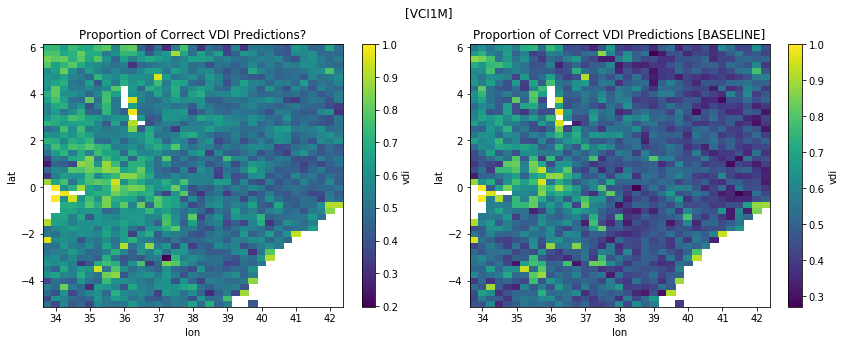

In [167]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
(vdi_lstm_pred_1M == vdi_true_1M).mean(dim='time').where(~mask).plot(ax=axs[0])
axs[0].set_title('Proportion of Correct VDI Predictions?');

(vdi_bline_1M == vdi_true_1M).mean(dim='time').where(~mask).plot(ax=axs[1])
axs[1].set_title('Proportion of Correct VDI Predictions [BASELINE]');

fig.suptitle('[VCI1M]')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

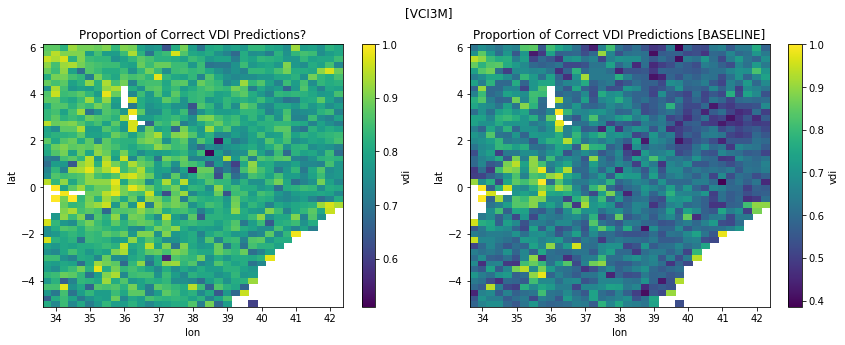

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
(vdi_lstm_pred_3M == vdi_true_3M).mean(dim='time').where(~mask).plot(ax=axs[0])
axs[0].set_title('Proportion of Correct VDI Predictions?');

(vdi_bline_3M == vdi_true_3M).mean(dim='time').where(~mask).plot(ax=axs[1])
axs[1].set_title('Proportion of Correct VDI Predictions [BASELINE]');

fig.suptitle('[VCI3M]')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot the Vegetation Deficit Index (VDI) from Klisch & Atzberger 2016

In [171]:
print(true_np_1M.shape)
print(preds_e1_np_1M.shape)
print(bline_np_1M.shape)


(151200,)
(151200,)
(151200,)


Normalized confusion matrix
[[3.17628651e-01 4.20636300e-01 1.92802503e-01 3.05111266e-02
  3.84214186e-02]
 [7.24070450e-02 3.86497065e-01 4.16714631e-01 8.20191090e-02
  4.23621503e-02]
 [1.22365954e-02 1.24813273e-01 4.94898770e-01 2.83126212e-01
  8.49251502e-02]
 [1.48056330e-03 2.41710567e-02 2.39300348e-01 4.54532934e-01
  2.80515098e-01]
 [2.26478582e-04 1.76329753e-03 2.96201631e-02 1.38556361e-01
  8.29833700e-01]]
Normalized confusion matrix
[[0.53833449 0.27390473 0.1233484  0.0238178  0.04059458]
 [0.17221135 0.36272591 0.34010591 0.07942903 0.0455278 ]
 [0.05028128 0.16749833 0.41032324 0.25995614 0.11194101]
 [0.01239541 0.05815515 0.24952656 0.35375133 0.32617154]
 [0.00171477 0.00820176 0.05212243 0.13459299 0.80336806]]


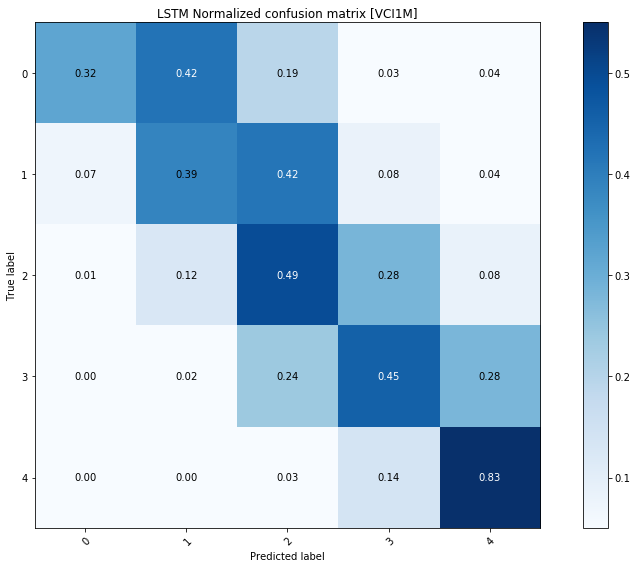

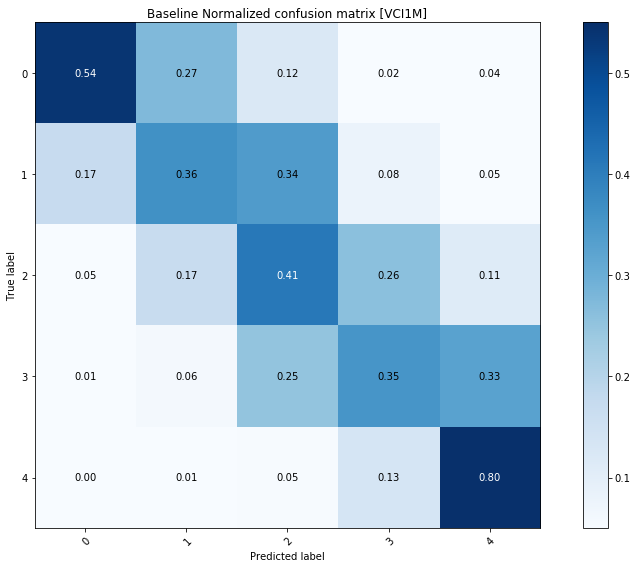

In [181]:
true_np_1M = vdi_true_1M.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_lstm_np_1M = vdi_lstm_pred_1M.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np_1M = vdi_bline_1M.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np_1M, preds_lstm_np_1M.clip(min=1, max=5), classes=None, normalize=True,
                      title='LSTM Normalized confusion matrix [VCI1M]',
                      **{'vmin': 0.05, 'vmax': 0.55});

plot_confusion_matrix(true_np_1M, bline_np_1M.clip(min=1, max=5), classes=None, normalize=True,
                      title='Baseline Normalized confusion matrix [VCI1M]',
                      **{'vmin': 0.05, 'vmax': 0.55});

Normalized confusion matrix
[[7.43403339e-01 2.35325794e-01 8.07754443e-04 0.00000000e+00
  2.04631125e-02]
 [6.84329406e-02 7.21628716e-01 1.87168061e-01 1.83139003e-04
  2.25871436e-02]
 [9.80333908e-04 7.41488919e-02 7.92555404e-01 1.14817896e-01
  1.74974749e-02]
 [0.00000000e+00 1.83105469e-04 1.21734619e-01 7.62969971e-01
  1.15112305e-01]
 [0.00000000e+00 0.00000000e+00 1.14827513e-04 5.89885337e-02
  9.40896639e-01]]
Normalized confusion matrix
[[6.54146473e-01 2.97792138e-01 2.71943996e-02 4.03877221e-04
  2.04631125e-02]
 [1.30883340e-01 5.16696172e-01 3.16586289e-01 1.31249618e-02
  2.27092363e-02]
 [9.17949023e-03 1.49515774e-01 5.72307052e-01 2.36557543e-01
  3.24401402e-02]
 [2.74658203e-04 1.12915039e-02 2.39257812e-01 5.07019043e-01
  2.42156982e-01]
 [0.00000000e+00 3.28078608e-05 1.07773823e-02 1.24194157e-01
  8.64995653e-01]]


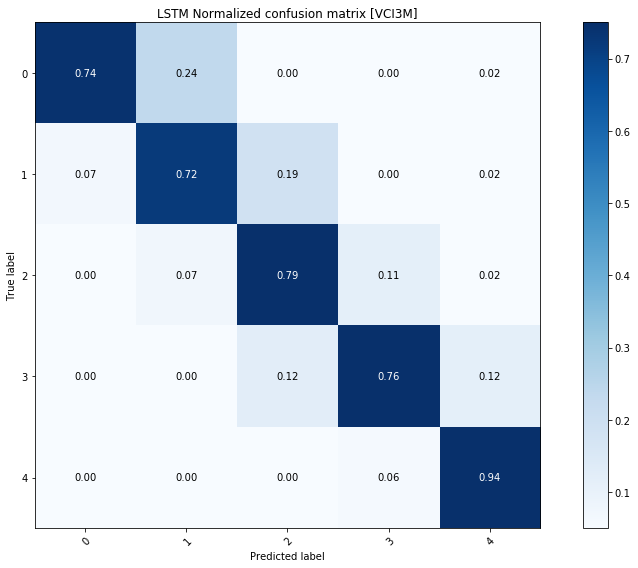

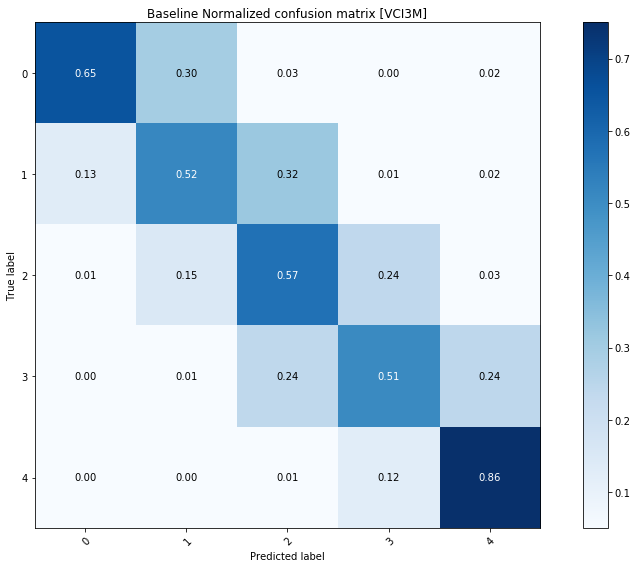

In [180]:
true_np_3M = vdi_true_3M.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_lstm_np_3M = vdi_lstm_pred_3M.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np_3M = vdi_bline_3M.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np_3M, preds_lstm_np_3M.clip(min=1, max=5), classes=None, normalize=True,
                      title='LSTM Normalized confusion matrix [VCI3M]',
                      **{'vmin': 0.05, 'vmax': 0.75});

plot_confusion_matrix(true_np_3M, bline_np_3M.clip(min=1, max=5), classes=None, normalize=True,
                      title='Baseline Normalized confusion matrix [VCI3M]',
                      **{'vmin': 0.05, 'vmax': 0.75});

## Why are the Adede baselines so different from the normal baselines?

In [ ]:
from src.analysis import VegetationDeficitIndex

Normalized confusion matrix
[[0.14873088 0.16872392 0.21140473 0.14673157 0.3244089 ]
 [0.10855301 0.15914585 0.22148037 0.15402325 0.35679751]
 [0.07510409 0.11766202 0.21758891 0.18412103 0.40552395]
 [0.05608925 0.097304   0.19564095 0.20118445 0.44978136]
 [0.05839912 0.09335771 0.19302446 0.19858936 0.45662935]]


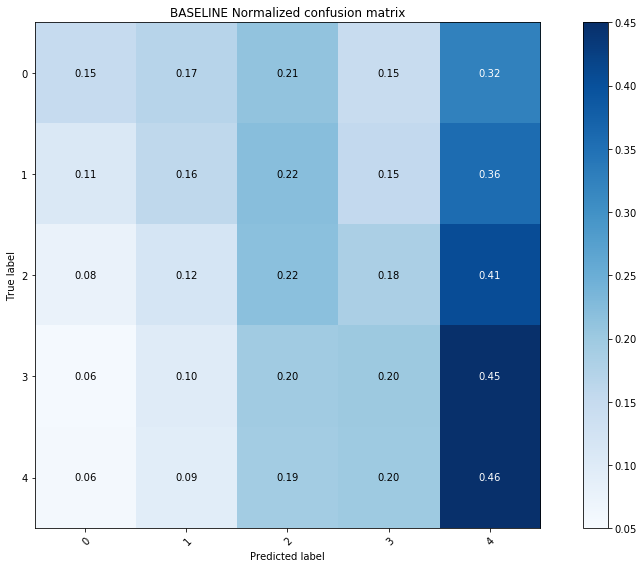

In [192]:
_bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
_, _y_test = read_test_data(data_dir)

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(_y_test.VCI, 'vdi')
vdi_bline = v.vegetation_index_classify(_bline_pred.load(), 'vdi')

true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np = vdi_bline.stack(pixel=['lat', 'lon']).values.flatten()

plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
                      title='BASELINE Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})

Normalized confusion matrix
[[0.53833449 0.27390473 0.1233484  0.0238178  0.04059458]
 [0.17221135 0.36272591 0.34010591 0.07942903 0.0455278 ]
 [0.05028128 0.16749833 0.41032324 0.25995614 0.11194101]
 [0.01239541 0.05815515 0.24952656 0.35375133 0.32617154]
 [0.00171477 0.00820176 0.05212243 0.13459299 0.80336806]]


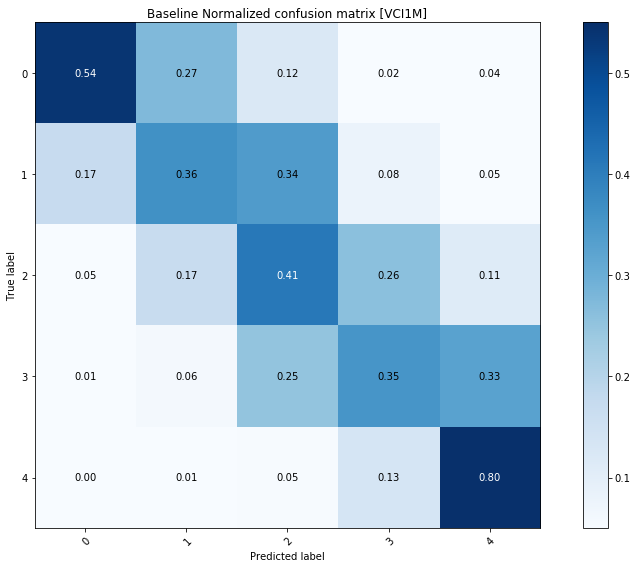

In [193]:
bline_pred_1M = read_pred_data('previous_month', data_dir, experiment='one_month_forecast_adede_only_target_VCI1M')[-1].where(~mask)
_, y_test_1M = read_test_data(data_dir, experiment='one_month_forecast_adede_VCI1M')

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true_1M = v.vegetation_index_classify(y_test_1M.VCI1M, 'vdi')
vdi_bline_1M = v.vegetation_index_classify(bline_pred_1M.load(), 'vdi')

true_np_1M = vdi_true_1M.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np_1M = vdi_bline_1M.stack(pixel=['lat', 'lon']).values.flatten()

plot_confusion_matrix(true_np_1M, bline_np_1M.clip(min=1, max=5), classes=None, normalize=True,
                      title='Baseline Normalized confusion matrix [VCI1M]',
                      **{'vmin': 0.05, 'vmax': 0.55});

# THIS NEEDS MORE WORK

# Regional Analysis

In [46]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer_1M = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment='one_month_forecast_adede_only_target_VCI1M',
    true_data_experiment='one_month_forecast_adede_VCI1M'
)

analyzer_3M = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment='one_month_forecast_adede_only_target_VCI3M',
    true_data_experiment='one_month_forecast_adede_VCI3M'
)


r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast_adede_only_target_VCI1M
Models: ['previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
Initialised the Region Analysis for experiment: one_month_forecast_adede_only_target_VCI3M
Models: ['previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
GroupbyRegion requires geopandas to be installed


In [42]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

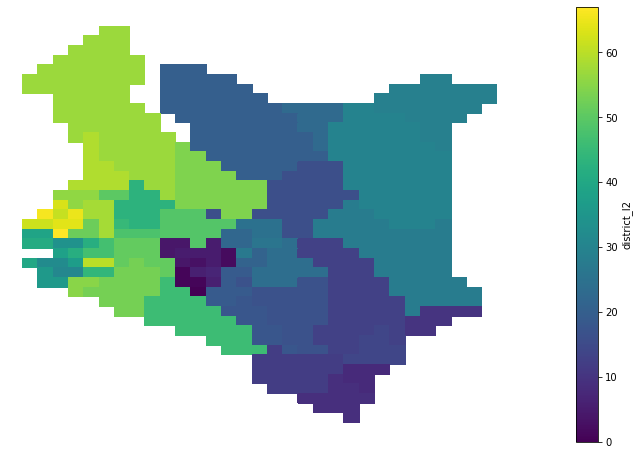

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
region_da.plot(ax=ax)
ax.set_axis_off()

# region_da.where(region_da == dict(zip(region_lookup.values(), region_lookup.keys()))['NAIROBI'])

In [44]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

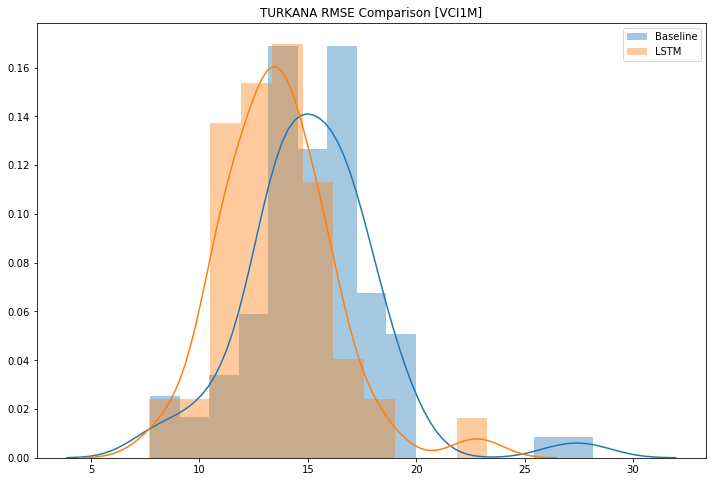

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
region = 'TURKANA'
msk = get_region_mask(region)
sns.distplot(drop_nans_and_flatten(bline_rmse_1M.where(msk)), label='Baseline')
sns.distplot(drop_nans_and_flatten(lstm_rmse_1M.where(msk)), label='LSTM')
ax.set_title(f'{region} RMSE Comparison [VCI1M]')
plt.legend();

### Make region dataframe

In [51]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer_1M = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment='one_month_forecast_adede_only_target_VCI1M',
    true_data_experiment='one_month_forecast_adede_VCI1M'
)

analyzer_3M = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment='one_month_forecast_adede_only_target_VCI3M',
    true_data_experiment='one_month_forecast_adede_VCI3M'
)

Initialised the Region Analysis for experiment: one_month_forecast_adede_only_target_VCI1M
Models: ['previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
Initialised the Region Analysis for experiment: one_month_forecast_adede_only_target_VCI3M
Models: ['previous_month', 'rnn']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries


In [54]:
import pickle
warnings.filterwarnings('ignore')

# if (data_dir / 'analysis/admin_region_analyzer_adede_only_1M.pkl').exists():
#     analyzer = pickle.load(open(data_dir / 'analysis/admin_region_analyzer_adede_only_1M.pkl', 'rb'))
# else:
analyzer_1M.analyze()
    
#     with open(data_dir / 'analysis/admin_region_analyzer_adede_only_1M.pkl', 'wb') as f:
#         pickle.dump(analyzer, f)
        
# if (data_dir / 'analysis/admin_region_analyzer_adede_only_3M.pkl').exists():
#     analyzer = pickle.load(open(data_dir / 'analysis/admin_region_analyzer_adede_only_1M.pkl', 'rb'))
# else:
analyzer_3M.analyze()
    
#     with open(data_dir / 'analysis/admin_region_analyzer_adede_only_3M.pkl', 'wb') as f:
#         pickle.dump(analyzer, f)

* Analyzing for district_l2_kenya *

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **

** Analyzing for rnn-district_l2_kenya **
** Written rnn csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/rnn/rnn_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_adede_only_target_VCI1M_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to data/analysis/region_analysis/regional_error_metrics_one_month_forecast_adede_only_target_VCI1M_admin.csv *
* Analyzing for district_l2_kenya *

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/an

In [57]:
region_plotter_1M = analyzer_1M.create_model_performance_by_region_geodataframe()
df_1M = analyzer_1M.df
gdf_1M = region_plotter_1M.gdf

region_plotter_3M = analyzer_3M.create_model_performance_by_region_geodataframe()
df_3M = analyzer_3M.df
gdf_3M = region_plotter_3M.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`
GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [59]:
# join true/preds into a GeoDataFrame
all_gdf_1M = region_plotter_1M.merge_all_model_performances_gdfs(analyzer_1M.df)
all_gdf_1M.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,previous_month,2011-01-31,NAIROBI,54.387498,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2011-01-31,NAIROBI,43.656448,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,rnn,2011-02-28,NAIROBI,46.621742,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,previous_month,2011-02-28,NAIROBI,56.869999,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2011-03-31,NAIROBI,63.476248,71.818748,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


In [60]:
# join true/preds into a GeoDataFrame
all_gdf_3M = region_plotter_3M.merge_all_model_performances_gdfs(analyzer_3M.df)
all_gdf_3M.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,previous_month,2011-01-31,NAIROBI,47.750165,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2011-01-31,NAIROBI,50.726181,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,rnn,2011-02-28,NAIROBI,53.319702,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,previous_month,2011-02-28,NAIROBI,54.895165,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2011-03-31,NAIROBI,58.244582,71.818748,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


### Spatial Patterns

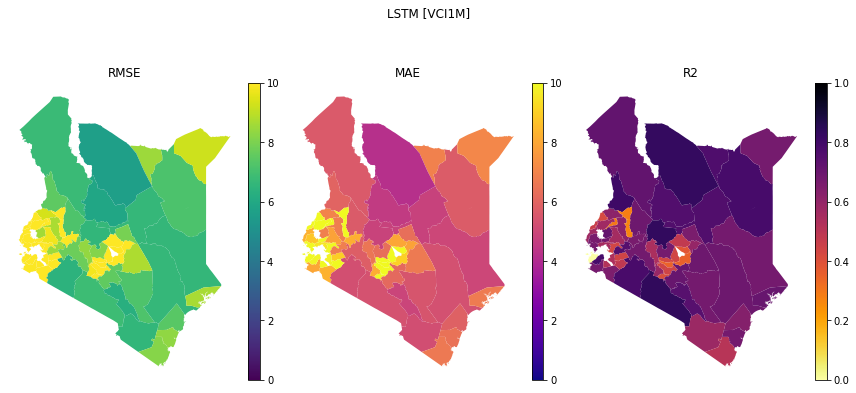

In [81]:
def plot_region_scores(region_plotter, gdf, model, rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0):
    region_plotter.plot_all_regional_error_metrics(
        gdf.where(gdf.model == model).dropna(),
        **dict(rmse_vmax=rmse_vmax, mae_vmax=mae_vmax, mae_vmin=mae_vmin, rmse_vmin=rmse_vmin)
    );
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
plot_region_scores(region_plotter_1M, gdf_1M, model='rnn', rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
fig = plt.gcf()
fig.suptitle('LSTM [VCI1M]')
fig.tight_layout(rect=[0, 0.03, 1, 1.15])


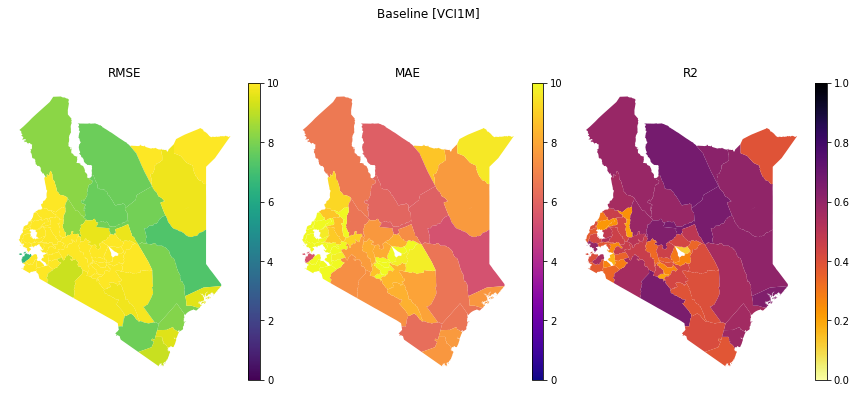

In [82]:
plot_region_scores(region_plotter_1M, gdf_1M, model='previous_month', rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
fig = plt.gcf()
fig.suptitle('Baseline [VCI1M]')
fig.tight_layout(rect=[0, 0.03, 1, 1.15])

### VCI 3M (something isn't working?)

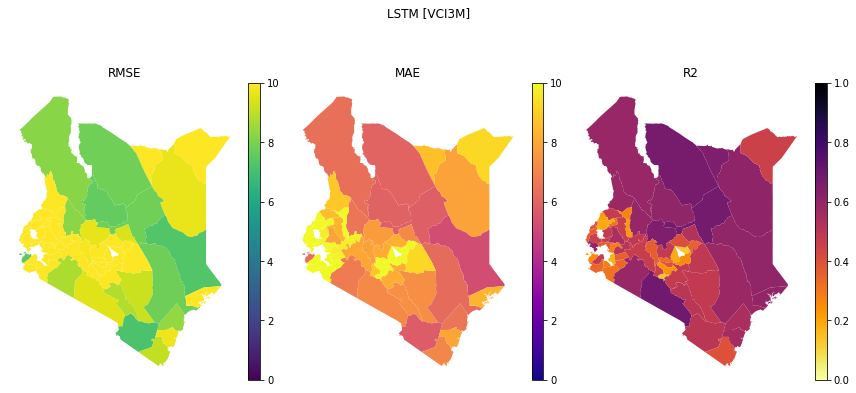

In [85]:
plot_region_scores(region_plotter_3M, gdf_3M, model='rnn', rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
fig = plt.gcf()
fig.suptitle('LSTM [VCI3M]')
fig.tight_layout(rect=[0, 0.03, 1, 1.15])

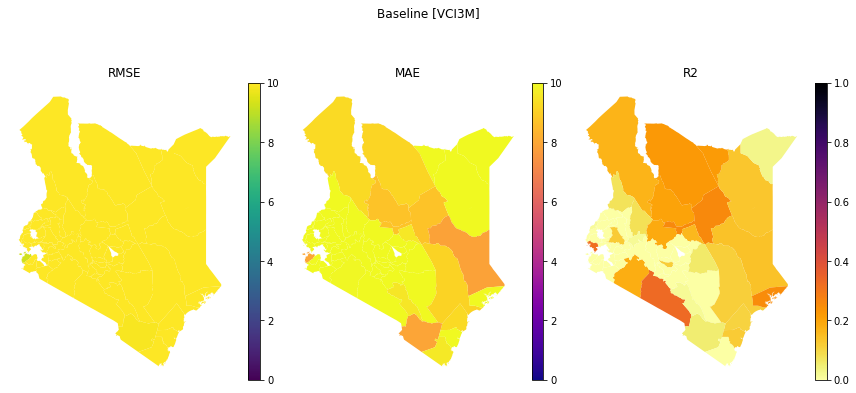

In [91]:
plot_region_scores(region_plotter_3M, gdf_3M, model='previous_month', rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
fig = plt.gcf()
fig.suptitle('Baseline [VCI3M]')
fig.tight_layout(rect=[0, 0.03, 1, 1.15])

## Explore Time series of predictions

In [96]:
all_gdf_1M.head()

,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,previous_month,2011-01-31,NAIROBI,54.387498,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2011-01-31,NAIROBI,43.656448,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,rnn,2011-02-28,NAIROBI,46.621742,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,previous_month,2011-02-28,NAIROBI,56.869999,63.476248,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2011-03-31,NAIROBI,63.476248,71.818748,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


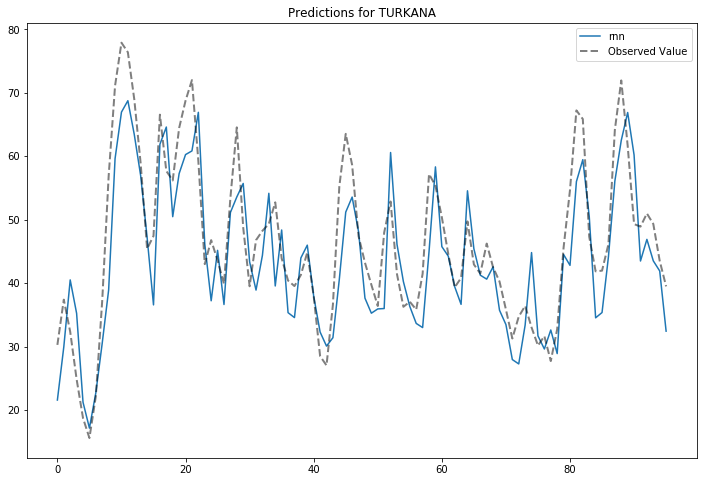

In [135]:
from typing import List
region = 'TURKANA'

def plot_region_comparisons(all_gdf, models: List[str], region: str):
    model_ts_list = []
    for model in models:
        model_ts_list.append(
            all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == model)].predicted_mean_value.rename(model)
        )
    true_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == models[0])].true_mean_value.rename('Observed Value')

    fig, ax = plt.subplots(figsize=(12, 8))
    for model_ts, model in zip(model_ts_list, models):
        model_ts.reset_index().drop(columns='index').plot(ax=ax, label=model)
    true_ts.reset_index().drop(columns='index').plot(ax=ax, label='Observation', color='k', alpha=0.5, ls='--', lw=2)
    
    ax.set_title(f'Predictions for {region}')
    plt.legend()
    
plot_region_comparisons(all_gdf_1M, models=['rnn'], region=region)

In [111]:
from typing import List

def plot_region_time_series(all_gdf, region: str, ax=None, model: List[str] = ['ealstm']):
    times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
    obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
    rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
    ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm_omf_static_embedding')].predicted_mean_value
    ealstm_bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
    lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
    ln_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_network')].predicted_mean_value
    bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'previous_month')].predicted_mean_value
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    df_dict = {'obs' : obs_ts.values}
    
    if 'lstm' in model:
        df_dict['lstm'] = rnn_ts.values
    if 'ealstm' in model:
        df_dict['ealstm'] = ealstm_ts.values
    if 'ealstm_bline' in model:
        df_dict['ealstm_bline'] = ealstm_bline_ts.values
    if 'lr' in model:
        df_dict['lr'] = lr_ts.values
    if 'ln' in model:
        df_dict['ln'] = ln_ts.values
    if 'baseline' in model:
        df_dict['baseline'] = bline_ts.values

    pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)

    ax.set_ylim(0, 100)
    ax.set_title(f'{region} Predicted vs. Modelled');
    
    return fig, ax


def plot_region_seasonality(region, ax=None):
    ts = (
        all_df
        .loc[:, ['datetime', region]
        ].set_index('datetime')
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');
    
    return fig, ax


def plot_region_vs_observed_seasonality(region, model, ax=None):
    ts = (
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region), 
            ['datetime', 'true_mean_value', 'predicted_mean_value']
        ].set_index('datetime')
    ).rename(
        columns={'true_mean_value': 'Observed', 'predicted_mean_value': f'Predicted ({model.upper()})'}
    )
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle for {region} District')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean VCI');

    return fig, ax

In [112]:
from sklearn.metrics import r2_score
from typing import Dict

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    """Over three months"""
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    
    return output_dict

In [113]:
print('Performance for LSTM VCI1M')
rolling_average(all_gdf_1M[all_gdf_1M.model == 'rnn']);
print()

print('Performance for Persistence VCI1M')
rolling_average(all_gdf_1M[all_gdf_1M.model == 'previous_month']);
print()

Performance for LSTM VCI1M
For Mandera, r2 score: 0.854823472088953
For Marsabit, r2 score: 0.9288678346384681
For Turkana, r2 score: 0.7243576451804336
For Wajir, r2 score: 0.9145696657872303

Performance for Persistence VCI1M
For Mandera, r2 score: 0.7418834628995075
For Marsabit, r2 score: 0.7987667508875049
For Turkana, r2 score: 0.680436164680156
For Wajir, r2 score: 0.7719722418377023



In [114]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


model = 'ealstm'
region = 'TURKANA'

# TURKANA explore

def plot_region_performance(all_gdf, model: str, region: str, kind='reg'):
    df = pd.DataFrame(
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region),
            ['datetime', 'predicted_mean_value', 'true_mean_value']
        ].set_index('datetime')
    )

    # sns.scatterplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
    # sns.lmplot(x='true_mean_value', y='predicted_mean_value', data=turkana)

    sns.jointplot(
        x='true_mean_value', y='predicted_mean_value', 
        data=df, kind=kind, stat_func=r2
    )
    
    ax = plt.gca()
    ax.set_xlabel(f'{region} - Observation')
    ax.set_ylabel(f'{region} - {model.upper()}');
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    fig = plt.gcf()
    # fig.set_size_inches(11.7, 8.27)
    fig.set_size_inches(8.27, 8.27)

    return fig, ax


In [116]:
def highlight_selected_regions(all_gdf, regions: List[str], scale=1):
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    gdf = all_gdf.loc[(all_gdf.model=='ealstm') & (all_gdf.datetime == '2011-01-31')]
    gdf.plot(ax=ax, color='#23748d')
    for region in regions:

        gdf_ = gdf.loc[gdf.region_name == region]
        gdf_.plot(color='#57bfd0', ax=ax, alpha=0.9)

        gdf_.apply(
            lambda x: ax.annotate(
                s=x.region_name, xy=x.geometry.centroid.coords[0], ha='center'
            ), 
            axis=1
        );


        ax.set_axis_off()
#         fig.savefig(f'/Users/tommylees/Downloads/{region}_maps.png', transparent=True)
#         plt.close()



regions = ['MARSABIT', 'TURKANA', 'WAJIR', 'MANDERA', 'SAMBURU', 'ISIOLO', 'LAIKIPIA', 'MOYALE', 'KAJIADO']
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']


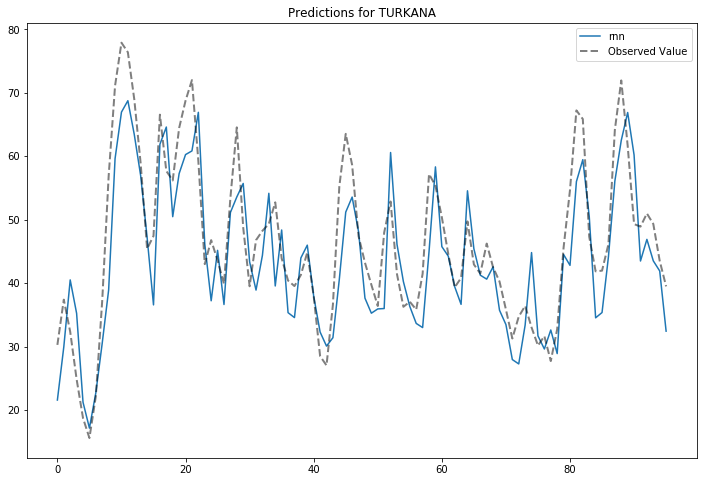

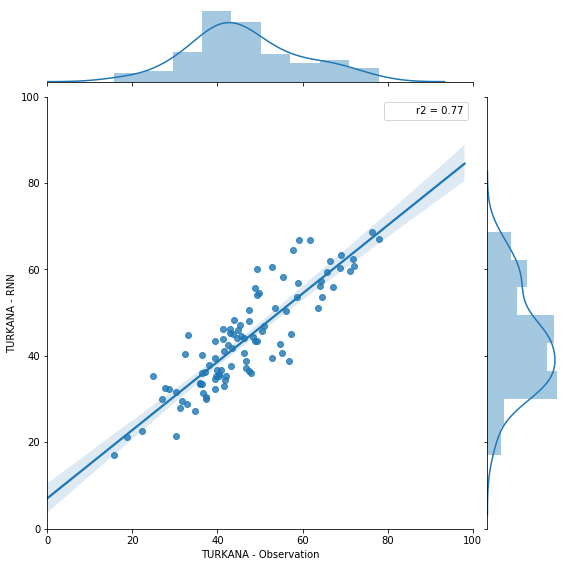

In [136]:
for region in regions[:1]:
    plot_region_comparisons(all_gdf_1M, region=region, models=['rnn'])
    fig, ax = plot_region_performance(all_gdf=all_gdf_1M, model='rnn', region=region);

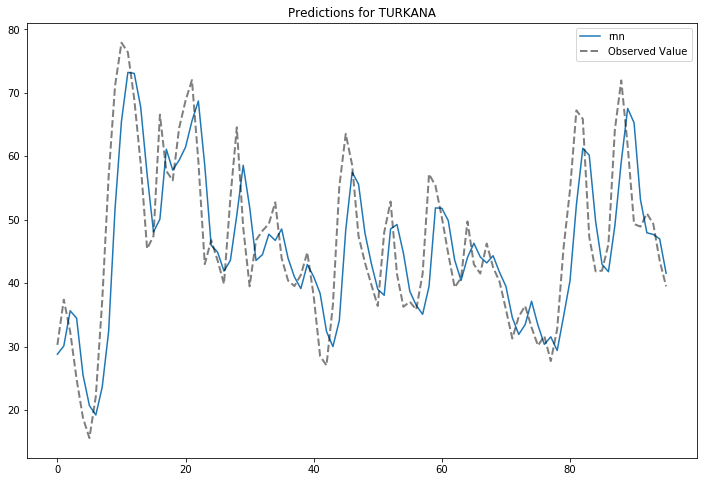

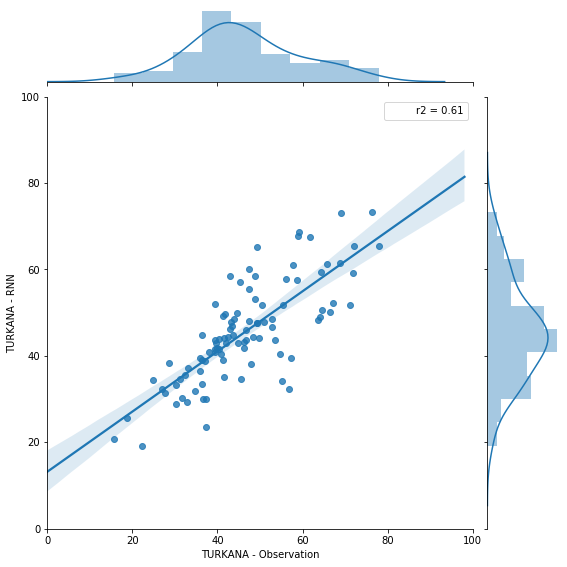

In [137]:
for region in regions[:1]:
    plot_region_comparisons(all_gdf_3M, region=region, models=['rnn'])
    fig, ax = plot_region_performance(all_gdf=all_gdf_3M, model='rnn', region=region);